# Определение возраста покупателей

**Описание проекта:**

Сетевой супермаркет внедряет систему компьютерного зрения для обработки фотографий покупателей. Фотофиксация в прикассовой зоне поможет определять возраст клиентов, чтобы:
Анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы;
Контролировать добросовестность кассиров при продаже алкоголя.
Постройте модель, которая по фотографии определит приблизительный возраст человека. В вашем распоряжении набор фотографий людей с указанием возраста.

**Описание данных:**

Данные взяты с сайта ChaLearn Looking at People.

В вашем распоряжении одна папка со всеми изображениями и CSV-файл labels.csv с двумя колонками: file_name и real_age. 

**План работы:**

- Провести исследовательский анализ набора фотографий.
- Подготовить данные к обучению.
- Обучить нейронную сеть и рассчитать её качество.

**Цель:**

Метрика MAE не должна превышать 8.

## Исследовательский анализ данных

### Загружаем библиотеки.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator

### Загружаем данные.

In [2]:
%%time
labels = pd.read_csv('/datasets/faces/labels.csv')
train_datagen = ImageDataGenerator(rescale=1./255)
train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=12345)

Found 7591 validated image filenames.
CPU times: user 602 ms, sys: 473 ms, total: 1.07 s
Wall time: 1min 26s


### Выводим на экран размер выборки.

In [3]:
print(f"Размер выборки: {labels.shape[0]} изображений")

Размер выборки: 7591 изображений


### Выводим на экран график распределения возраста в выборке.

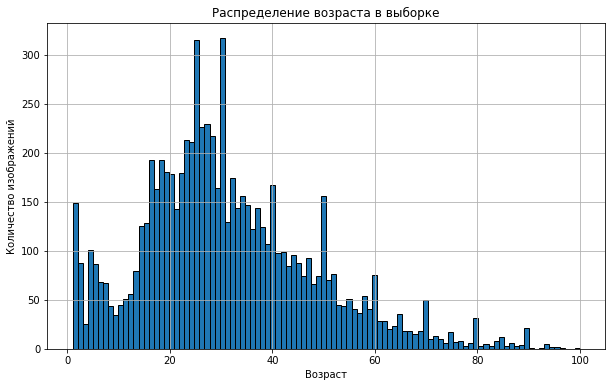

In [4]:
plt.figure(figsize=(10, 6))
labels['real_age'].hist(bins=100, edgecolor='black')
plt.title('Распределение возраста в выборке')
plt.xlabel('Возраст')
plt.ylabel('Количество изображений')
plt.grid(True)
plt.show()

### Выводим на экран 15 фотографий из выборки.

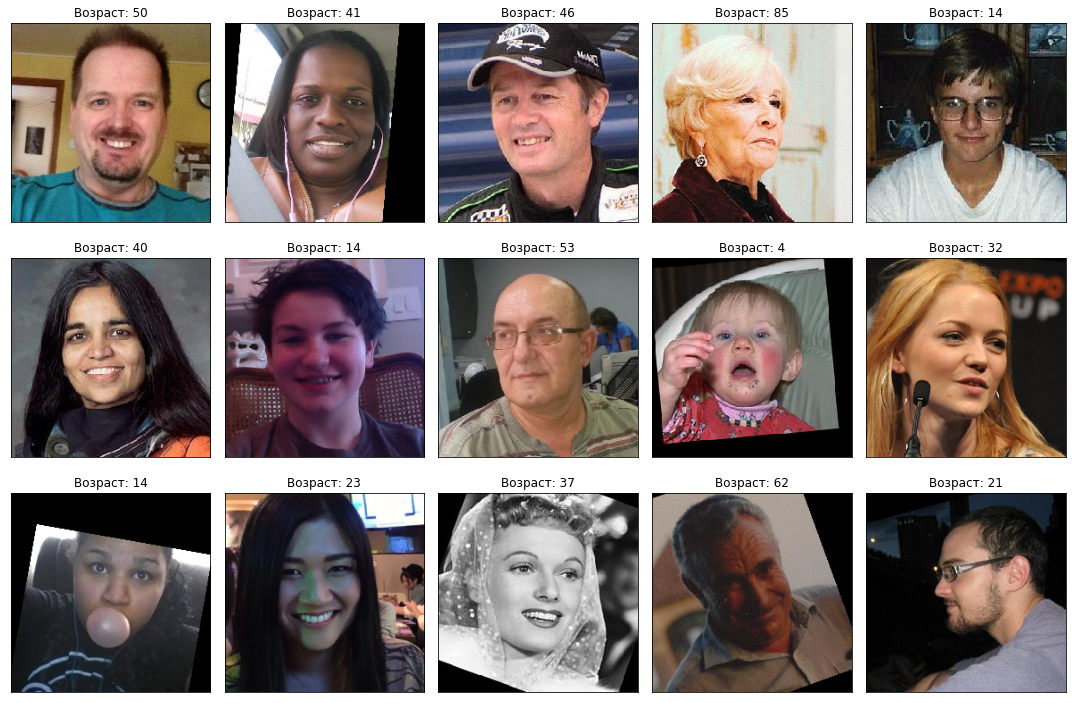

CPU times: user 1.68 s, sys: 146 ms, total: 1.82 s
Wall time: 3.1 s


In [5]:
%%time
features, target = next(train_gen_flow)
plt.figure(figsize=(15,10))
for i in range(15):
    plt.subplot(3,5,i+1)
    plt.imshow(features[i])
    plt.title(f"Возраст: {target[i]}")
    plt.xticks([])
    plt.yticks([])
plt.tight_layout()
plt.show()

### Выводы по итогам исследовательского анализа данных:

- В датасете всего 7591 изображений.
- Изображения людей различных возрастов распределены в датасете неравномерно. Подавляющее количество изображений относятся к людям в возрасте от 13 до 40 лет.
- Изображения не единообразны:
    - подавляющее большинство изображений цветные, но есть и черно-белые;
    - подавляющее большинство изображений en face, но есть и в профиль;
    - на изображениях присуствует шум - черные рамки, не несущие информации для нейросети.
- Пики в районе "юбилейных" возрастов, вероятно, связаны с тем, что люди, размечавшие возраст по фотографиям, округляли его.

## Обучение модели

Код из этого раздела запускался в отдельном GPU-тренажёре, поэтому оформлен не как ячейка с кодом, а как код в текстовой ячейке.

```python

from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
import numpy as np
import pandas as pd


def load_train(path):
    labels = pd.read_csv(f'{path}/labels.csv')
    train_datagen = ImageDataGenerator(
    validation_split=0.25,
    rescale=1/255.,
    horizontal_flip=True)
    
    train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory=f'{path}/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='training',
        seed=12345)

    return train_gen_flow

def load_test(path):
    labels = pd.read_csv(f'{path}/labels.csv')
    test_datagen = ImageDataGenerator(
    validation_split=0.25,
    rescale=1/255.)
    
    test_gen_flow = test_datagen.flow_from_dataframe(
        dataframe=labels,
        directory=f'{path}/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='validation',
        seed=12345)

    return test_gen_flow

def create_model(input_shape):

    backbone = ResNet50(input_shape=(224, 224, 3),
                    weights='imagenet',
                    include_top=False)
    
    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu'))

    optimizer = Adam(lr=0.0001)
    model.compile(optimizer=optimizer, loss='mean_squared_error',
                  metrics=['mae'])


    return model


def train_model(model, train_data, test_data, batch_size=None, epochs=10,
                steps_per_epoch=None, validation_steps=None):

    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)
    if validation_steps is None:
        validation_steps = len(test_data)

    model.fit(train_data,
              validation_data=test_data,
              batch_size=batch_size, epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2)

    return model

```

**Результат обучения нейросети в тренажере:**

```

Train for 178 steps, validate for 60 steps
Epoch 1/10
178/178 - 72s - loss: 242.2564 - mae: 11.0261 - val_loss: 565.0734 - val_mae: 18.7386
Epoch 2/10
178/178 - 38s - loss: 74.6800 - mae: 6.5290 - val_loss: 706.6372 - val_mae: 21.6143
Epoch 3/10
178/178 - 38s - loss: 48.3985 - mae: 5.3046 - val_loss: 222.1570 - val_mae: 11.0384
Epoch 4/10
178/178 - 38s - loss: 37.6165 - mae: 4.6610 - val_loss: 136.3873 - val_mae: 8.8281
Epoch 5/10
178/178 - 38s - loss: 26.7706 - mae: 3.9642 - val_loss: 82.1680 - val_mae: 6.9283
Epoch 6/10
178/178 - 38s - loss: 20.1950 - mae: 3.4614 - val_loss: 76.1147 - val_mae: 6.7658
Epoch 7/10
178/178 - 38s - loss: 17.4947 - mae: 3.1958 - val_loss: 64.4721 - val_mae: 6.0108
Epoch 8/10
178/178 - 38s - loss: 13.3934 - mae: 2.8073 - val_loss: 60.3613 - val_mae: 5.7804
Epoch 9/10
178/178 - 38s - loss: 11.1487 - mae: 2.5303 - val_loss: 68.9062 - val_mae: 6.1692
Epoch 10/10
178/178 - 41s - loss: 9.8191 - mae: 2.3661 - val_loss: 62.2064 - val_mae: 5.8585
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
60/60 - 10s - loss: 62.2064 - mae: 5.8585

```

## Анализ обученной модели

- Была выбрана модель нейронной сети ResidualNetwork50, предобученная на наборе данных ImageNet, c подстройкой под параметры задачи регрессии (один нейрон в выходном слое и функция активации ReLu).
- Функция потерь - MSE, метрика качества - MAE, оптимизатор - Adam с коэффициентом обучения 0,0001.
- После масштабирования значений пикселей изображений модель позволила добиться минимально необходимой метрики.
- Метрику удалось улучшить после добавления аугментации с отражением горизонтали.
- Максимальной метрики удалось добиться после подбора оптимального количества эпох.